# UNet+VGG16 9
This is the 9th iteration of UNet+VGG16

In this iteration I:
- change dropout rate from 0.3 to 0.45


**NOTE:** Connect to a High-RAM Environment with GPU enabled

# Training

Settings

In [1]:
# Check for GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# MODEL SETTINGS
model_name = 'unet_vgg_9'  # Name of the model
percentage_to_load = 50 / 100.0  # Set the % of dataset to be loaded here.
threshold = 0.75  # Set the threshold for metrics here
initial_lr = 0.01  # Learning rate at the beginning of training (NOT INCORPORATED CURRENTLY, set at 1e-4)
print(f'\nSETTINGS:')
print(f'Model Name: {model_name}')
print(f'Percentage to Load: {percentage_to_load*100}%')
print(f'Threshold: {threshold}')
print(f'Initial Learning Rate: {initial_lr}')
print()

# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

# Imports
import os
import cv2
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, Flatten, Conv2DTranspose
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tqdm import tqdm

Num GPUs Available:  1

SETTINGS:
Model Name: unet_vgg_9
Percentage to Load: 50.0%
Threshold: 0.75
Initial Learning Rate: 0.01

Mounted at /gdrive


Data Loading

In [2]:
# Function to count files
def count_files(directory, extension=".tif"):
    return sum(1 for file in os.listdir(directory) if file.endswith(extension))

# Paths to your image and mask directories
image_directory = '/gdrive/My Drive/Dataset/patches/train/images/'
mask_directory = '/gdrive/My Drive/Dataset/patches/train/masks/'

# Counting the TIFF files in both directories
image_count = count_files(image_directory)
mask_count = count_files(mask_directory)

print(f"Number of image files: {image_count}")
print(f"Number of mask files: {mask_count}")

# Load the images and masks into the lists below
images = []
masks = []

# Sort filenames to ensure matching pairs align
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".tif")])
mask_files = sorted([f for f in os.listdir(mask_directory) if f.endswith(".tif")])

# Determine how many files to load based on percentage
number_of_files_to_load = int(len(image_files) * percentage_to_load)

# Create a mapping of image names to their corresponding mask names by removing '_Buildings'
image_to_mask = {f: f.replace("_patch", "_Buildings_patch") for f in image_files}

# Only iterate over the subset of files determined by the percentage
print(f'Attempting to load {percentage_to_load*100}% of dataset: {number_of_files_to_load} images/mask pairs...')
for count, image_name in enumerate(tqdm(image_files[:number_of_files_to_load]), start=1):
    try:
        img_path = os.path.join(image_directory, image_name)
        mask_name = image_to_mask[image_name]
        mask_path = os.path.join(mask_directory, mask_name)

        if os.path.exists(mask_path):
            img = tiff.imread(img_path)
            mask = tiff.imread(mask_path)

            images.append(img)
            masks.append(mask)
        else:
            print(f'\nMask not found for image: {image_name}')
    except Exception as e:
        print(f'\nError loading image/mask pair {image_name}: {e}')

print("\nLoading complete.")

# Check if the number of images and masks loaded are equal
if len(images) != len(masks):
    raise ValueError("The number of loaded images and masks do not match!")

Number of image files: 4787
Number of mask files: 4787
Attempting to load 50.0% of dataset: 2393 images/mask pairs...


100%|██████████| 2393/2393 [30:30<00:00,  1.31it/s]


Loading complete.


Normalization & Train/Test/Val Split

In [3]:
# Convert the lists to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

# Normalize the values
images /= 255.0
masks /= 255.0
masks = masks.reshape((-1, 256, 256, 1))

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=1995)

# Further split the training set into training and validation sets (90% train, 10% val)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1995)

# If X_train, X_test, X_val have an extra unnecessary dimension at axis=1, remove it:
X_train = X_train.squeeze(axis=1)
X_test = X_test.squeeze(axis=1)
X_val = X_val.squeeze(axis=1)

# Display the shapes of the datasets to confirm correct dimensions
print('Dataset Shapes:')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_val:   {X_val.shape}, y_val: {y_val.shape}')
print(f'X_test:  {X_test.shape}, y_test: {y_test.shape}')

Dataset Shapes:
X_train: (1722, 256, 256, 3), y_train: (1722, 256, 256, 1)
X_val:   (192, 256, 256, 3), y_val: (192, 256, 256, 1)
X_test:  (479, 256, 256, 3), y_test: (479, 256, 256, 1)


Metrics & Loss

Class weights: {0: 0.5339968946194886, 1: 7.853612816644959}


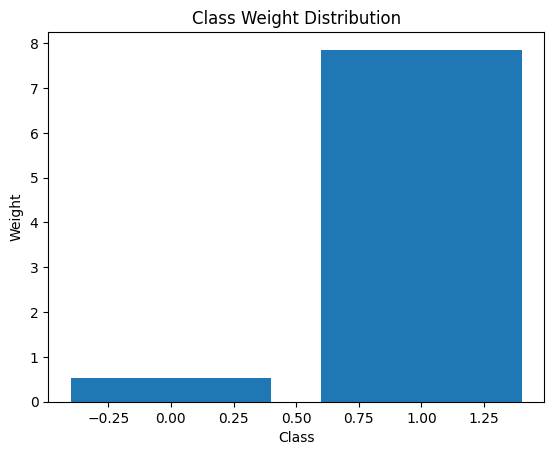

In [4]:
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# CUSTOM METRICS

# Dice Coefficient: Measures overlap between true and predicted masks.
def dice_coefficient(y_true, y_pred, threshold=threshold):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

# Jaccard Index: Measures the ratio of intersection to the union of true and predicted masks.
def jaccard_index(y_true, y_pred, threshold=threshold):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

# Sensitivity: Measures the proportion of actual positives correctly identified.
def sensitivity(y_true, y_pred, threshold=threshold):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.float32)
    true_positives = tf.reduce_sum(y_true_f * y_pred_f)
    possible_positives = tf.reduce_sum(y_true_f)
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

# Specificity: Measures the proportion of actual negatives correctly identified.
def specificity(y_true, y_pred, threshold=threshold):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.float32)
    true_negatives = tf.reduce_sum((1-y_true_f) * (1-y_pred_f))
    possible_negatives = tf.reduce_sum(1-y_true_f)
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Precision: Measures the proportion of predicted positives that are actually true positives.
def precision(y_true, y_pred, threshold=threshold):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.float32)
    true_positives = tf.reduce_sum(y_true_f * y_pred_f)
    predicted_positives = tf.reduce_sum(y_pred_f)
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())


# LOSS FUNCTION
def calculate_class_weights(masks):
    flat_labels = masks.flatten().astype(int)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(flat_labels), y=flat_labels)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    return class_weights_dict

def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        weighted_bce = bce * (weights[1] * y_true + weights[0] * (1 - y_true))
        return tf.keras.backend.mean(weighted_bce)
    return loss

# Calculate the class weights for the training masks
class_weights = calculate_class_weights(y_train)
print("Class weights:", class_weights)

# Visualize class weight distribution
plt.bar(class_weights.keys(), class_weights.values())
plt.title("Class Weight Distribution")
plt.xlabel("Class")
plt.ylabel("Weight")
plt.show()

weighted_loss = weighted_binary_crossentropy(class_weights)

Model Definition

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def vgg16_unet(input_size=(256, 256, 3), freeze_vgg16=True, dropout_rate=0.45):
    inputs = Input(input_size)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    if freeze_vgg16:
        # Freeze the VGG16 layers
        for layer in vgg16.layers:
            layer.trainable = False

    # Skip connections from VGG16 layers
    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output
    bridge = vgg16.get_layer("block5_conv3").output

    # Decoder with dropout
    up1 = UpSampling2D((2, 2))(bridge)
    up1 = concatenate([up1, s4])
    up1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    up1 = Dropout(dropout_rate)(up1)

    up2 = UpSampling2D((2, 2))(up1)
    up2 = concatenate([up2, s3])
    up2 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    up2 = Dropout(dropout_rate)(up2)

    up3 = UpSampling2D((2, 2))(up2)
    up3 = concatenate([up3, s2])
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = Dropout(dropout_rate)(up3)

    up4 = UpSampling2D((2, 2))(up3)
    up4 = concatenate([up4, s1])
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    up4 = Dropout(dropout_rate)(up4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up4)

    model = Model(inputs, outputs)
    return model

Model Compilation

In [6]:
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define the model
model = vgg16_unet()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=weighted_loss,
    metrics=['accuracy', dice_coefficient, jaccard_index, sensitivity, specificity, precision]
)

model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                             

Model Training

In [7]:
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=15,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    f'/gdrive/My Drive/Dataset/Models/best_{model_name}.h5',  # Path where the model will be saved
    monitor='val_dice_coefficient',  # Save the model based on the maximum dice_coefficient value
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Fit the model
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=50,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint, early_stopping]
)

# Save the model
model.save(f'/gdrive/My Drive/Dataset/Models/{model_name}.h5')
print(f'Model saved to: /gdrive/My Drive/Dataset/Models/{model_name}.h5')

Epoch 1/50
216/216 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.7240 - dice_coefficient: 0.3124 - jaccard_index: 0.1877 - sensitivity: 0.4374 - specificity: 0.8995 - precision: 0.2564
Epoch 1: val_dice_coefficient improved from -inf to 0.40399, saving model to /gdrive/My Drive/Dataset/Models/best_unet_vgg_9.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


216/216 [==============================] - 51s 163ms/step - loss: 0.5693 - accuracy: 0.7240 - dice_coefficient: 0.3124 - jaccard_index: 0.1877 - sensitivity: 0.4374 - specificity: 0.8995 - precision: 0.2564 - val_loss: 0.3987 - val_accuracy: 0.7372 - val_dice_coefficient: 0.4040 - val_jaccard_index: 0.2542 - val_sensitivity: 0.5028 - val_specificity: 0.9359 - val_precision: 0.3418
Epoch 2/50
215/216 [============================>.] - ETA: 0s - loss: 0.4078 - accuracy: 0.7648 - dice_coefficient: 0.3913 - jaccard_index: 0.2448 - sensitivity: 0.5291 - specificity: 0.9210 - precision: 0.3168
Epoch 2: val_dice_coefficient improved from 0.40399 to 0.42889, saving model to /gdrive/My Drive/Dataset/Models/best_unet_vgg_9.h5
216/216 [==============================] - 33s 155ms/step - loss: 0.4078 - accuracy: 0.7647 - dice_coefficient: 0.3912 - jaccard_index: 0.2447 - sensitivity: 0.5296 - specificity: 0.9208 - precision: 0.3166 - val_loss: 0.3589 - val_accuracy: 0.7926 - val_dice_coefficient: 0

# Evaluation

Evaluation

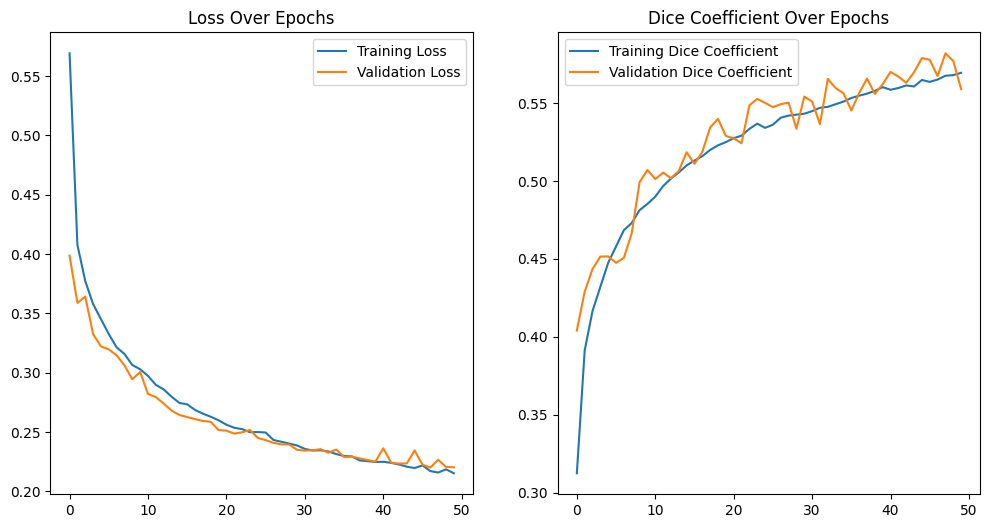

15/15 [==============================] - 31s 1s/step


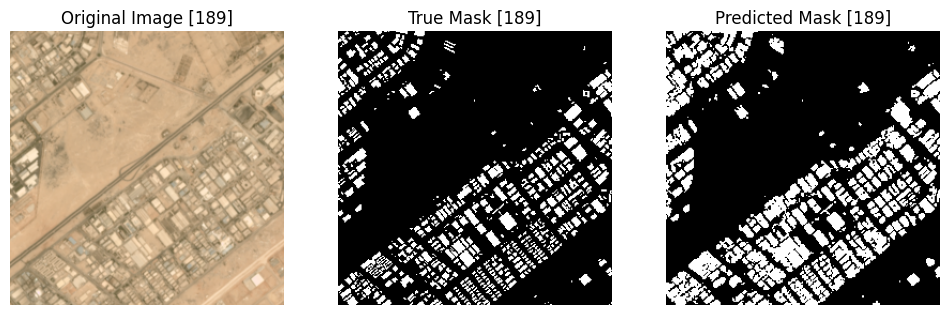

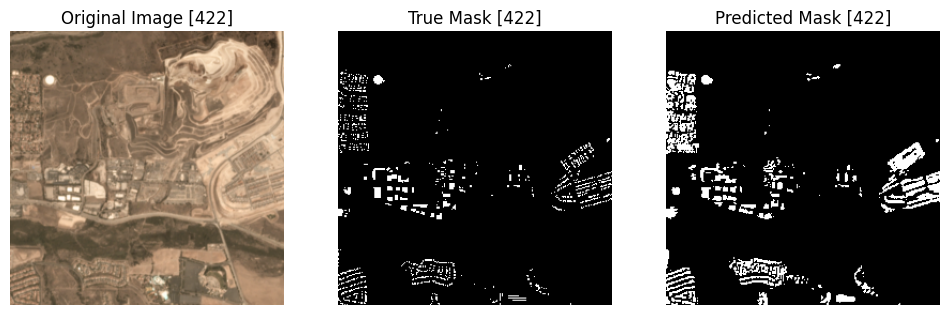

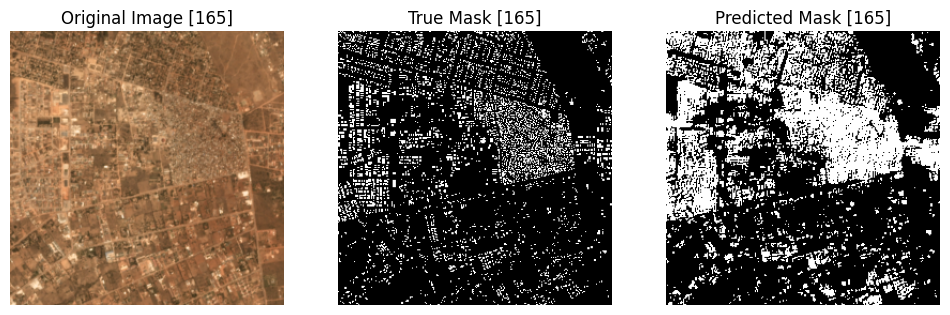

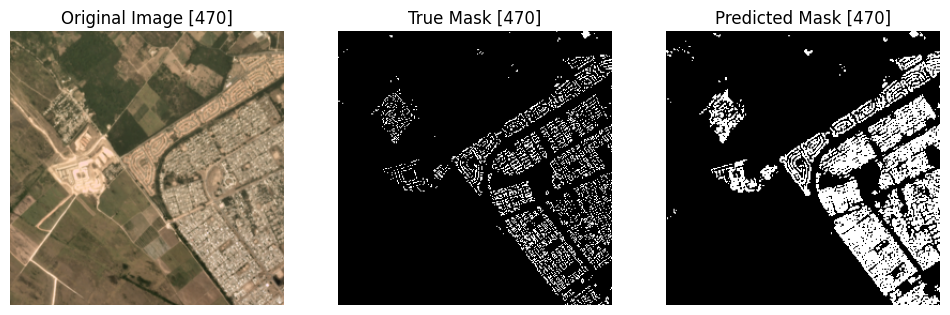

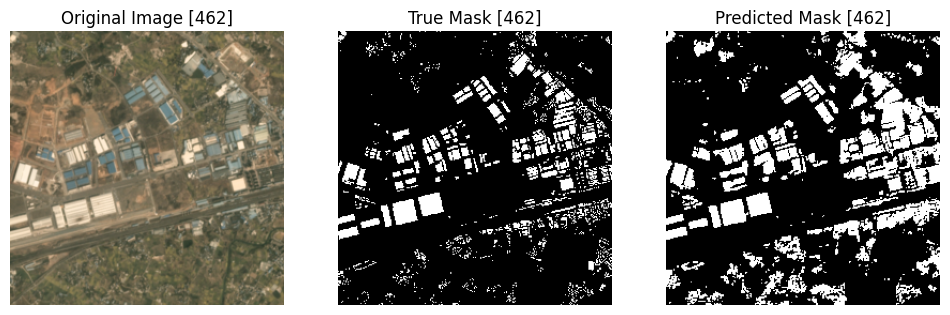

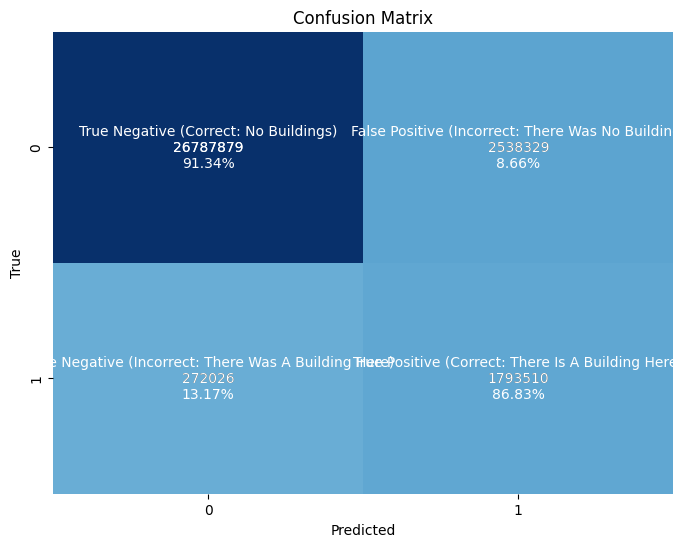

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95  29326208
         1.0       0.41      0.87      0.56   2065536

    accuracy                           0.91  31391744
   macro avg       0.70      0.89      0.76  31391744
weighted avg       0.95      0.91      0.92  31391744

ROC-AUC: 0.9630035042527285


In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score

# Evaluation functions
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient Over Epochs')
    plt.legend()

    plt.show()

def show_predictions(X, y_true, y_pred, threshold=threshold, num_samples=5):
    indices = np.random.choice(range(len(X)), num_samples, replace=False)

    for i in indices:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(X[i])
        plt.title(f'Original Image [{i}]')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title(f'True Mask [{i}]')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[i].squeeze() > threshold, cmap='gray')  # Apply a threshold to convert probabilities to binary mask
        plt.title(f'Predicted Mask [{i}]')
        plt.axis('off')

        plt.show()

def plot_confusion_matrix(y_true, y_pred, threshold=threshold):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > threshold).astype(int)  # Thresholding probabilities

    cm = confusion_matrix(y_true_f, y_pred_f)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    labels = ['True Negative (Correct: No Buildings)', 'False Positive (Incorrect: There Was No Building)', 'False Negative (Incorrect: There Was A Building Here)', 'True Positive (Correct: There Is A Building Here)']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm_normalized.flatten()]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, center=0)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Perform the evaluation
plot_training_history(history)
y_pred = model.predict(X_test)
show_predictions(X_test, y_test, y_pred, threshold=threshold)
plot_confusion_matrix(y_test, y_pred, threshold=threshold)
print(classification_report(y_test.flatten(), (y_pred.flatten() > threshold).astype(int)))
print("ROC-AUC:", roc_auc_score(y_test.flatten(), y_pred.flatten()))